In [3]:
!ls

BD25d4655.0168b.fits SN2009ip.0167r.fits  bias-low.0015r.fits
BD25d4655.0168r.fits arc30s.0010b.fits    bias-low.0016b.fits
BIAS.fits            arc30s.0010r.fits    bias-low.0016r.fits
FLAT.fits            arc30s.0011b.fits    bias-low.0017b.fits
PyDIS Practice.ipynb arc30s.0011r.fits    bias-low.0017r.fits
README.txt           arc30s.0012b.fits    bias-low.0018b.fits
SN2009ip.0165b.fits  arc30s.0012r.fits    bias-low.0018r.fits
SN2009ip.0165r.fits  bbias.txt            r300flat.0013r.fits
SN2009ip.0166b.fits  bias-low.0014b.fits  rbias.txt
SN2009ip.0166r.fits  bias-low.0014r.fits  rflat.txt
SN2009ip.0167b.fits  bias-low.0015b.fits


In [30]:
!ls r300* > rflat.txt
!ls bias*b.fits > bbias.txt
!ls bias*r.fits > rbias.txt

In [1]:
import pydis

In [5]:
#Let's reduce the red channel first! 
#Start with biases and flats

rbias = pydis.biascombine('rbias.txt', trim=True)

flat, fmask_out = pydis.flatcombine('rflat.txt', rbias, trim=True, mode='spline', response=True, display=True)
#First observation: with only one flat in the list, when pyDIS tries to read it, it can't tell the length of the resulting array
#Obviously with one flat image, we don't need to flatcombine, but I'm just using it as a shorthand for 
#from astropy.io import fits
#foo = fits.open(image)
#flat = foo[0].data

In [6]:
HeNeAr_file10r = 'arc30s.0010r.fits'

wfit10 = pydis.HeNeAr_fit(HeNeAr_file10r, trim=True, fmask=fmask_out, interac=True, mode='poly', fit_order=5)
#This is just an example for the manual calibration so I'm only going to use this arc image.
#I'm also going to do an autocalibrate; we'll see how that goes.

Running HeNeAr_fit function on file arc30s.0010r.fits

Using INTERACTIVE HeNeAr_fit mode:
1) Click on HeNeAr lines in plot window
2) Enter corresponding wavelength in terminal and press <return>
   If mis-click or unsure, just press leave blank and press <return>
3) To delete an entry, click on label, enter "d" in terminal, press <return>
4) Close plot window when finished
> Enter Wavelength: 9657.78
  Saving 9657.78
> Enter Wavelength: 9122.97
  Saving 9122.97
> Enter Wavelength: 8424.65
  Saving 8424.65
> Enter Wavelength: 8377.61
  Saving 8377.61
> Enter Wavelength: 8115.31
  Saving 8115.31
> Enter Wavelength: 7635.11
  Saving 7635.11
> Enter Wavelength: 7438.9
  Saving 7438.9
> Enter Wavelength: 7383.98
  Saving 7383.98
> Enter Wavelength: 7245.17
  Saving 7245.17
> Enter Wavelength: 7065.19
  Saving 7065.19
> Enter Wavelength: 7032.41
  Saving 7032.41
> Enter Wavelength: 6965.43
  Saving 6965.43
> Enter Wavelength: 
> Warning: Not a valid wavelength float!
> Enter Wavelength: 6402

In [9]:
#Now let's reduce the science images. I'm getting a divide by zero. Not sure if that's supposed to happen.

# the science image file name
spec = 'SN2009ip.0165r.fits'

# open the image, get the data and a couple important numbers
img = pydis.OpenImg(spec, trim=True)
raw = img.data
exptime = img.exptime
airmass = img.airmass

# remove bias and flat, divide by exptime
data = ((raw - rbias) / flat) / exptime

/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in divide


In [14]:
#And now the standard star

stspec = 'BD25d4655.0168r.fits'

stimg = pydis.OpenImg(stspec, trim=True)
straw = stimg.data
stexptime = stimg.exptime
stairmass = stimg.airmass

stdata= ((straw - rbias) / flat) / stexptime

/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


In [2]:
#Let's take a look at what we have so far

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

plt.imshow(np.log10(data), origin='lower',aspect='auto',cmap=cm.Greys_r)

Tracing Aperture using nsteps=50


/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/pydis-1.0-py2.7.egg/pydis/pydis.py:550: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img),origin='lower',aspect='auto',cmap=cm.Greys_r)
/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/pydis-1.0-py2.7.egg/pydis/pydis.py:550: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img),origin='lower',aspect='auto',cmap=cm.Greys_r)


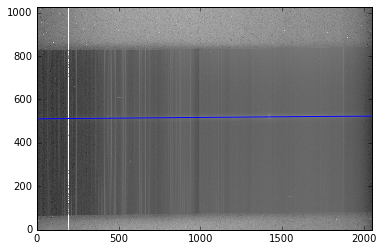

> Trace gaussian width = 4.80095630423 pixels


In [18]:
# trace the science image
trace = pydis.ap_trace(data, fmask=fmask_out, nsteps=50, interac=False, display=True)

Tracing Aperture using nsteps=50


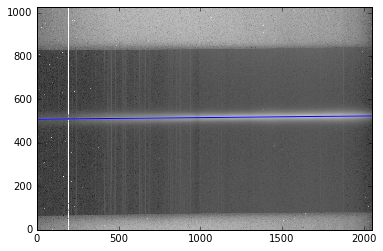

> Trace gaussian width = 5.14845292161 pixels


In [19]:
# trace the flux standard image
stdtrace = pydis.ap_trace(stdata, fmask=fmask_out, nsteps=50, interac=False, display=True)

In [20]:
#Now, to extract the spectrum!

ext_spec, sky, fluxerr = pydis.ap_extract(data, trace, apwidth=5,skysep=1, skywidth=7, skydeg=0)
ext_std, stdsky, stderr = pydis.ap_extract(stdata, stdtrace, apwidth=5, skysep=1, skywidth=7, skydeg=0)

# subtract the sky from the 1-d spectrum
flux_red = (ext_spec - sky) # the reduced object
flux_std = (ext_std - stdsky) # the reduced flux standard

/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/trevorzaylen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


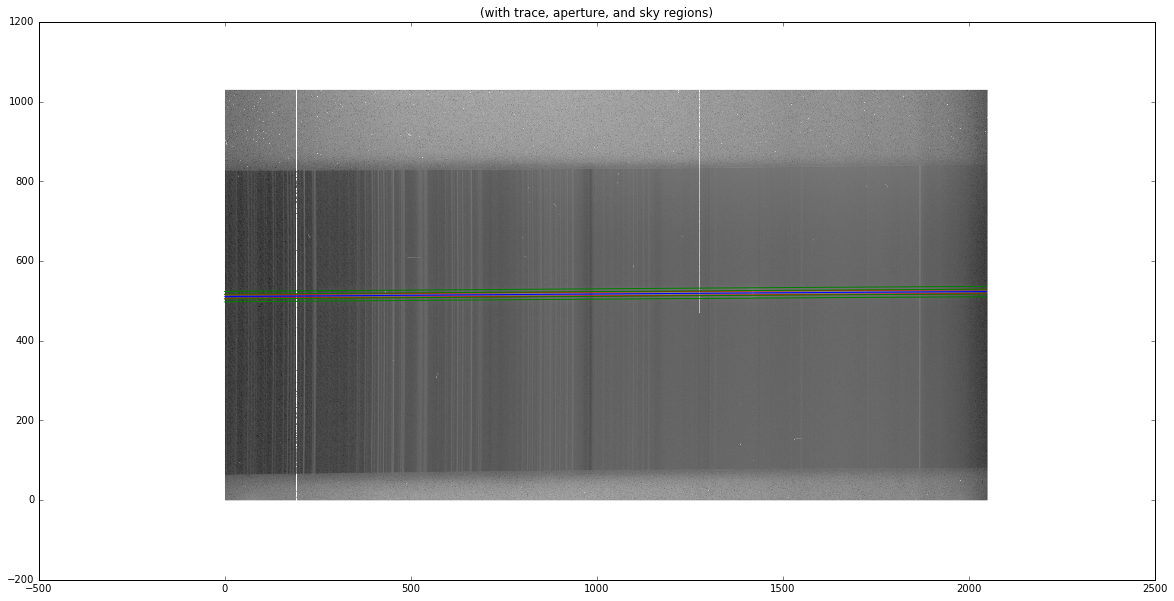

In [25]:
# Let's check that the extraction parameters are good

xbins = np.arange(data.shape[1])

fig,ax = plt.subplots(figsize = (20,10))

ax.imshow(np.log10(data), origin='lower',aspect='auto',cmap=cm.Greys_r)

# the trace
ax.plot(xbins, trace,'b',lw=1)

# the aperture
ax.plot(xbins, trace-5.,'r',lw=1)
ax.plot(xbins, trace+5.,'r',lw=1)

# the sky regions
ax.plot(xbins, trace-5.-1.,'g',lw=1)
ax.plot(xbins, trace-5.-1.-7.,'g',lw=1)
ax.plot(xbins, trace+5.+1.,'g',lw=1)
ax.plot(xbins, trace+5.+1.+7.,'g',lw=1)

plt.title('(with trace, aperture, and sky regions)')

In [27]:
#Wavelength calibration

wfinal = pydis.mapwavelength(trace, wfit10, mode='poly')
wfinalstd = pydis.mapwavelength(stdtrace, wfit10, mode='poly')

# correct the object and flux std for airmass extinction
flux_red_x = pydis.AirmassCor(wfinal, flux_red, airmass, airmass_file='apoextinct.dat')
flux_std_x = pydis.AirmassCor(wfinalstd, flux_std, stairmass, airmass_file='apoextinct.dat')

> Loading airmass library file: apoextinct.dat
> Loading airmass library file: apoextinct.dat


In [29]:
#Now to flux-calibrate...

sensfunc = pydis.DefFluxCal(wfinalstd, flux_std_x, mode='spline', stdstar='ctiocal/bd25.dat')

# final step in reduction, apply sensfunc
ffinal,efinal = pydis.ApplyFluxCal(wfinal, flux_red_x, fluxerr, wfinalstd, sensfunc)

(3.8541664901676521e-17, 5.2216449596334093e-15)

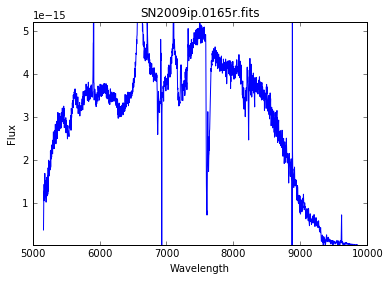

In [31]:
#The final spectrum...
#Not the prettiest but I sped through the reduction just to see how the manual reduction felt.
#Let's try the autoreduction

plt.plot(wfinal, ffinal)
#plt.errorbar(wfinal, ffinal, yerr=efinal)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(spec)
#plot within percentile limits
plt.ylim( (np.percentile(ffinal,2),
           np.percentile(ffinal,98)) )

In [49]:
#Now let's try the autoreduce function. First we need to get our files in a row...
!ls *.01*r.fits > objlist.r.txt
flatstring = ['r300flat.0013r.fits','r300flat.0013r.fits']
np.savetxt('flatlist.r.txt',flatstring,fmt='%s')
!ls bias*r.fits > biaslist.r.txt

In [52]:
#Note: with matplotlib inline turned on, THIS DOES NOT WORK
%matplotlib osx

#Note: this doesn't even work in an ipython notebook!
wave, flux, err = pydis.autoreduce('objlist.r.txt', 'flatlist.r.txt', 'biaslist.r.txt', 'arc30s.0010r.fits', stdstar='ctiocal/bd25.dat')

Running HeNeAr_fit function on file arc30s.0010r.fits

Using INTERACTIVE HeNeAr_fit mode:
1) Click on HeNeAr lines in plot window
2) Enter corresponding wavelength in terminal and press <return>
   If mis-click or unsure, just press leave blank and press <return>
3) To delete an entry, click on label, enter "d" in terminal, press <return>
4) Close plot window when finished
> You have identified 0 lines


TypeError: expected non-empty vector for x

> Enter Wavelength: 

# To do:
# 1√. HeNeAr solutions for all arc*.r.fits images
# 2√. Reduce Science images
# 3√. Find and trace spectrum
# 4√. Calibrate spectrum
# 5√. Flux calibration
# 6√. Make it work with the autoreduce function

In [53]:
#results from autoreduce:
wav,flux,err = np.genfromtxt('SN2009ip.0165r.fits.spec',unpack=True)

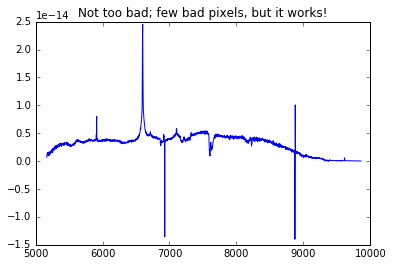

In [55]:
%matplotlib inline

plt.plot(wav,flux)
plt.title('Not too bad; few bad pixels, but it works!')

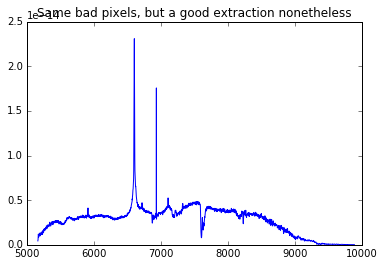

In [3]:
#What about a coadded version? It uses the same wavelength solution (and I didn't set the HeNeAr
#fitting to interactive), but we can coadd these images! We have the power!

wav,flux,err = np.genfromtxt('ReduceCoAdd.txt',unpack=True)

plt.plot(wav,flux)
plt.title('Same bad pixels, but a good extraction nonetheless')